In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

import pickle
import os

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Data
1 - Positive

2 - Neutral

3 - Negative

In [3]:
dataset_path = "Data/news_headlines_data.csv"

In [4]:
df = pd.read_csv(dataset_path)
df = df.iloc[:, [0, 2]]
print(df['Headlines'][4])

Tesla shares have fallen 28% since Elon Musk took over Twitter, lagging other carmakers


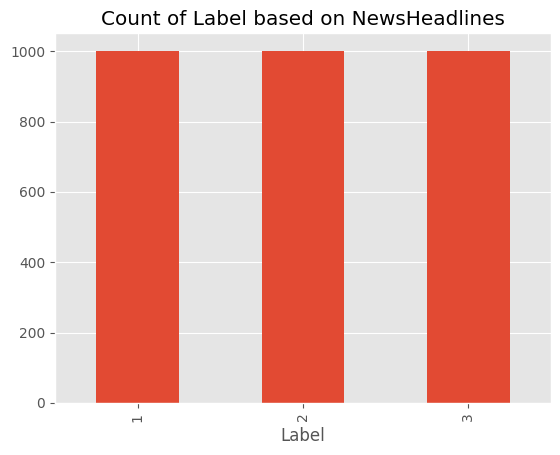

In [5]:
ax = df['Label'].value_counts().sort_index().plot(kind='bar', title="Count of Label based on NewsHeadlines").figsize=(10, 5)


# Preprocessing
## lowercase, remove stopwords, remove punctuation

In [18]:
def lemmatize_word(word, pos_tag):
    # map NLTK POS tags to WordNet POS tags
    pos_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'J': wordnet.ADJ,
        'R': wordnet.ADV
    }
    # lemmatize the word
    pos = pos_map.get(pos_tag[0], wordnet.NOUN)
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, pos)

def remove_punctuation(text):
  # replace punctuation marks with an empty string
  from string import punctuation
  punctuation += '’'
  translator = str.maketrans('', '', punctuation)
  return text.translate(translator)

In [19]:
def preprocess_text(df_column:pd.core.series.Series):

  stopwords_list = set(stopwords.words('english'))

  # remove stop words
  df_column = df_column.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stopwords_list]))
  # remove punctuation
  df_column = df_column.apply(remove_punctuation)
  # tokenize and apply POS tagging and lemmatization
  df_column = df_column.apply(lambda x: ' '.join([lemmatize_word(word, tag) for word, tag in pos_tag(word_tokenize(x))]))

  return df_column

In [ ]:
df['Headlines'] = preprocess_text(df['Headlines'])

In [ ]:
print("After Preprocessing:")
print(df['Headlines'][3:7])

After Preprocessing:
3    apple stock touch alltime high amid big plan d...
4    tesla share fall 28 since elon musk take twitt...
5    meta stock jump company report first revenue g...
6    strange thing return boost netflix subscriber ...
Name: Headlines, dtype: object


# Training

In [ ]:
x = df['Headlines']
y = df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 17, shuffle = True)

train_headlines = x_train
test_headlines = x_test

In [ ]:
# implement BAG OF WORDS
countvector=CountVectorizer(ngram_range=(1,2))
traindataset=countvector.fit_transform(train_headlines)

In [ ]:
# implement RandomForest Classifier
randomclassifier=RandomForestClassifier(n_estimators=450,criterion='entropy')
randomclassifier.fit(traindataset,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=450)

In [ ]:
## Predict for the Test Dataset
test_transform= []
test_transform = test_headlines
test_dataset = countvector.transform(test_transform)
predictions = randomclassifier.predict(test_dataset)

# Compute Accuracy based on test dataset

In [ ]:
## Import library to check accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
# CONFUSION MATRIX
matrix=confusion_matrix(y_test,predictions)
print(matrix)
score=accuracy_score(y_test,predictions)
print(score)
report=classification_report(y_test,predictions)
print(report)

[[129  41  23]
 [ 67 127  10]
 [ 52  19 133]]
0.6472545757071547
              precision    recall  f1-score   support

           1       0.52      0.67      0.59       193
           2       0.68      0.62      0.65       204
           3       0.80      0.65      0.72       204

    accuracy                           0.65       601
   macro avg       0.67      0.65      0.65       601
weighted avg       0.67      0.65      0.65       601



In [ ]:
# import pickle

# # Assuming you have a trained RandomForestClassifier model called 'model'
# model = randomclassifier

# # Save the model to a file
# filename = 'random_forest_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(model, file)


# main

In [11]:
# specify the paths to your model and CountVectorizer files
model_path = "Model/random_forest_model.pkl"
vectorizer_path = "Model/countvector.pkl"

# load the trained model
with open(model_path, "rb") as f:
    model = pickle.load(f)

# load the trained CountVectorizer
with open(vectorizer_path, "rb") as f:
    countvector = pickle.load(f)

In [20]:
import gradio as gr

def predict(news_headlines):
    d = {'headline': [news_headlines]}
    temp_df = pd.DataFrame(data=d)
    temp_df['headline'] = preprocess_text(temp_df['headline'])


    preprocessed_text = temp_df['headline'][0]

    news_headline_vector = countvector.transform(temp_df['headline'])
    predictions = model.predict(news_headline_vector)


    output = ''
    if predictions == 1:
        output = "Positive"
    elif predictions == 3:
        output = "Negative"
    else:
        output = "Neutral"



    return preprocessed_text, output

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder="News Headline Here..."),
    outputs=["text", "text"]
)
demo.launch()


Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In [21]:
'''
SHORT TEST DATA

Tesla stock rises again, for record 12-day win streak
Twitter’s Stock Falls Further as Doubts Swirl Over Musk’s Takeover
Is Apple Stock a Buy Near $185?
'''

'\nTEST DATA\nTesla stock rises again, for record 12-day win streak\nTwitter’s Stock Falls Further as Doubts Swirl Over Musk’s Takeover\nIs Apple Stock a Buy Near $185?\n'